# Problema 1 - Generador Pseudoaleatorio Uniforme

Implementar un generador de números pseudo-aleatorios de tipo LCG (*linear congruential generator*), para generar:

1. Una muestra uniforme finita con valores $x_1, x_2, \ldots, x_n$.

2. Una muestra de una distribución uniforme $Unif(0,1)$.

Defina usted los parámetros: el módulo $m$, las constantes $(0 \le a, c < m)$, y el tamaño $N$ de la muestra generada, y repita sus experimentos para 2 conjuntos diferentes de parámetros.

En ambos casos, muestre estadísticos, histogramas y elabore una prueba de hipótesis para contrastar la muestra generada contra la muestra requerida, para determinar el buen funcionamiento del generador pseudo aleatorio. Use como tamaño de muestra un valor adecuado de $N$.

## Librerías

In [1]:
import math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from tabulate import tabulate

## Clase LCG

In [2]:
class LinearCongruentialGenerator:
    """lcg clásico con interfaz simple"""

    def __init__(self, m=2**32, a=1664525, c=1013904223, seed=1):
        self.m = int(m)
        self.a = int(a)
        self.c = int(c)
        self.state = int(seed) % self.m

    def nextInt(self):
        """retorna entero en [0, m-1]"""
        self.state = (self.a * self.state + self.c) % self.m
        return self.state

    def nextFloat(self):
        """retorna flotante en (0,1)"""
        return self.nextInt() / self.m

    def sequenceInt(self, size):
        """size enteros en [0, m-1]"""
        return np.fromiter((self.nextInt() for _ in range(size)), dtype=np.uint64, count=size)

    def sequenceFloat(self, size):
        """size flotantes en (0,1)"""
        return np.fromiter((self.nextFloat() for _ in range(size)), dtype=np.float64, count=size)

## Funciones auxiliares

In [3]:
def sampleUniformFinite(rng, n_values, size):
    # mapea enteros del lcg a {0,1,...,n_values-1}
    ints = rng.sequenceInt(size)
    return (ints % n_values).astype(np.int64)

In [4]:
def basicStats(x):
    # resumen rápido de una muestra
    x = np.asarray(x)
    lag1 = np.corrcoef(x[:-1], x[1:])[0, 1] if x.size > 1 else np.nan
    return {
        "n": x.size,
        "min": float(np.min(x)),
        "max": float(np.max(x)),
        "mean": float(np.mean(x)),
        "std": float(np.std(x, ddof=1)) if x.size > 1 else float("nan"),
        "lag1_autocorr": float(lag1),
    }

In [5]:
def chiSquareTestFinite(sample, n_values):
    # contraste para uniforme discreta sobre k = n_values categorías
    counts = np.bincount(sample, minlength=n_values)
    expected = np.full(n_values, len(sample) / n_values, dtype=np.float64)
    chi2, p = stats.chisquare(counts, f_exp=expected)
    return {"statistic": float(chi2), "pvalue": float(p), "k": int(n_values), "counts": counts}

In [6]:
def ksTestUniform01(u):
    # ks de una muestra (0,1) contra uniforme(0,1)
    ks = stats.kstest(u, "uniform", args=(0, 1))
    return {"statistic": float(ks.statistic), "pvalue": float(ks.pvalue)}

In [7]:
def plotHistogram(x, bins=50, title="", density=True, show=True, range_=None):
    # histograma simple con overlay opcional para Unif(0,1)
    plt.figure()
    plt.hist(x, bins=bins, density=density, edgecolor="black", range=range_)
    plt.title(title)
    plt.xlabel("valor")
    plt.ylabel("densidad" if density else "frecuencia")
    if show:
        plt.show()

## Función principal

In [8]:
def runP1Experiment(
    N=20000,
    n_values=32,
    lcg_params_1=dict(m=2**32, a=1664525, c=1013904223, seed=12345),
    lcg_params_2=dict(m=2**31, a=1103515245, c=12345, seed=98765),
    histogram_bins=50,
    make_plots=True,
    verbose=True,
    return_logs=True,
):
    results = []
    logs = []

    for idx, params in enumerate([lcg_params_1, lcg_params_2], start=1):
        rng = LinearCongruentialGenerator(**params)
        x_disc = sampleUniformFinite(rng, n_values, N)
        stats_disc = basicStats(x_disc)
        chi = chiSquareTestFinite(x_disc, n_values)

        u = rng.sequenceFloat(N)
        stats_cont = basicStats(u)
        ks = ksTestUniform01(u)

        if make_plots:
            plotHistogram(x_disc, bins=n_values,
                          title=f"exp{idx} — uniforme discreta {{0,...,{n_values-1}}}",
                          density=False, range_=(-0.5, n_values - 0.5))
            plotHistogram(u, bins=histogram_bins,
                          title=f"exp{idx} — Unif(0,1) (N={N})",
                          density=True, range_=(0.0, 1.0))

        table = [
            ["discreta", stats_disc["mean"], stats_disc["std"], stats_disc["lag1_autocorr"], chi["statistic"], chi["pvalue"]],
            ["Unif(0,1)", stats_cont["mean"], stats_cont["std"], stats_cont["lag1_autocorr"], ks["statistic"], ks["pvalue"]],
        ]

        if verbose:
            print(f"\n=== experimento {idx} | params: {params} | N={N} ===")
            print(tabulate(table, headers=["muestra", "media", "desv", "autocorr_lag1", "estadístico", "pvalue"]))

        results.append({
            "experiment": idx,
            "params": params,
            "N": N,
            "n_values": n_values,
            "discrete": {"stats": stats_disc, "chi_square": chi},
            "uniform01": {"stats": stats_cont, "ks_test": ks},
            "table": table
        })

        if return_logs:
            logs.append({
                "experiment": idx,
                "notes": ["LCG clásico", "chi-cuadrado (discreta)", "KS (Unif(0,1))",
                          "con N≥20k los resultados se estabilizan"]
            })

    return {"results": results, "logs": logs if return_logs else None}

## Ejecución

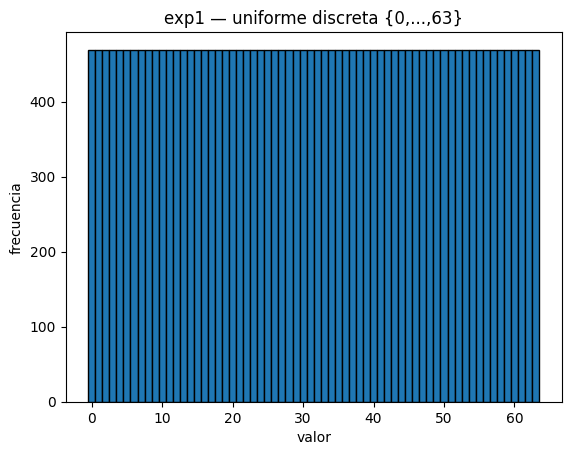

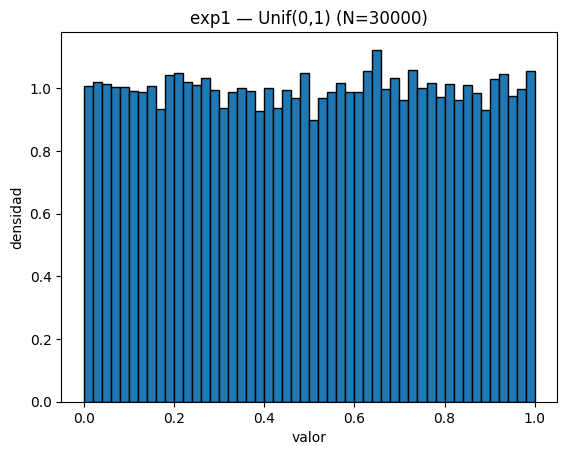


=== experimento 1 | params: {'m': 4294967296, 'a': 1664525, 'c': 1013904223, 'seed': 12345} | N=30000 ===
muestra        media       desv    autocorr_lag1    estadístico    pvalue
---------  ---------  ---------  ---------------  -------------  --------
discreta   31.4995    18.4731         -0.135374      0.0256       1
Unif(0,1)   0.500659   0.289484       -0.0047995     0.00520024   0.39043


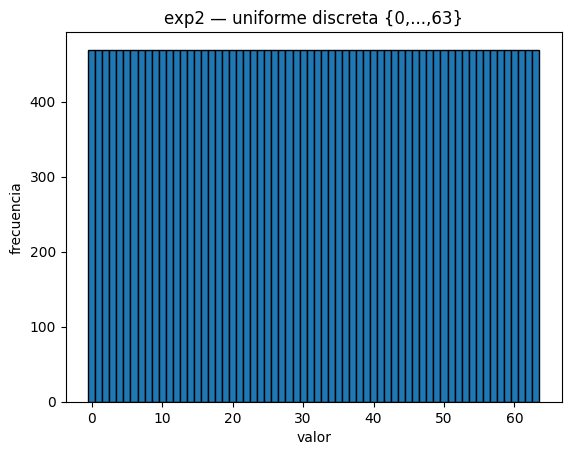

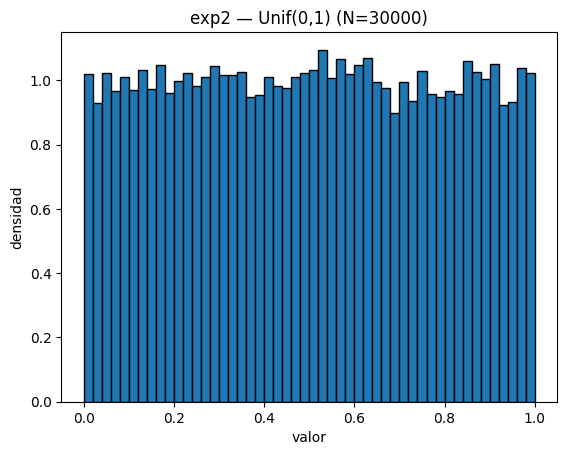


=== experimento 2 | params: {'m': 2147483648, 'a': 1103515245, 'c': 12345, 'seed': 98765} | N=30000 ===
muestra        media       desv    autocorr_lag1    estadístico    pvalue
---------  ---------  ---------  ---------------  -------------  --------
discreta   31.4989    18.4745       -0.00656563      0.0256      1
Unif(0,1)   0.499553   0.287812     -6.00322e-05     0.00653715  0.153244


In [9]:
experiment_data = runP1Experiment(
    N=30000,
    n_values=64,
    make_plots=True,
    verbose=True
)

In [10]:
experiment_data["logs"]

[{'experiment': 1,
  'notes': ['LCG clásico',
   'chi-cuadrado (discreta)',
   'KS (Unif(0,1))',
   'con N≥20k los resultados se estabilizan']},
 {'experiment': 2,
  'notes': ['LCG clásico',
   'chi-cuadrado (discreta)',
   'KS (Unif(0,1))',
   'con N≥20k los resultados se estabilizan']}]